<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINN_method_for_1D_Burgers'_equation_forward_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on method presented in:  
*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*  
https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import pandas as pd

from time import perf_counter

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git &> /dev/null
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions
import physicsInformedNeuralNetworks

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Finite difference solver

In [3]:
# solves 1D Burgers' equations using devito finite difference computation
def devitoSolver_1D_Burgers(tResolution, xResolution, tMin, tMax, xMin, xMax, l1, l2):
    # define discretisation
    # extent x direction
    extent_x = xMax - xMin
    # number of x grid points
    nx = xResolution
    # x direction step size
    dx = extent_x / (nx - 1)
    # time extent (total duration)
    T = tMax - tMin
    # time step
    dt = 1e-4
    # number of time points
    nt = int(T / dt)

    # create 1D grid and assign dimension variable names
    grid = Grid(shape=(nx), extent=(extent_x))
    x = grid.dimensions
    t = grid.stepping_dim
    # create time function on grid
    # space order of 2 to enable 2nd derivative
    u = TimeFunction(name='u', grid=grid, space_order=2)
    # create constant (viscosity)
    a = Constant(name='a')
    b = Constant(name='b')
    # define 1D Burgers' equation
    equation_u = Eq(u.dt + a*u*u.dxl, b*u.dx2)
    # create stencil by solving for next time step
    stencil_u = solve(equation_u, u.forward)
    # define equation for next time step
    update_u = Eq(u.forward, stencil_u)
    # define boundary conditions
    # u = 0 at min and max extent of x
    boundaryConditions = [Eq(u[t+1, 0], 0.)]
    boundaryConditions += [Eq(u[t+1, nx], 0.)]
    # define operator based on equation and boundary conditions
    op = Operator([update_u] + boundaryConditions)

    # set solution space to 0s
    u.data[:] = 0
    # create a dummy x array from -1 to +1
    dummyX = np.arange(-1, 1+dx, dx)
    # set initial conditions using dummy x array
    u.data[0] = -1 * np.sin(np.pi * dummyX)

    # define number of time steps to compute before storing result
    batchSize = int(nt/tResolution)

    # initialise empty array to store computed solution
    results = np.zeros((nx, tResolution))
    # store initial conditions in results array
    results[:,0] = u.data[0].copy()

    # log start time to measure performance
    startTime = perf_counter()

    # iterate over result steps
    # start from 1 not 0 as results at step 0 are the initial conditions
    for timeStep in range(1, tResolution):
        # compute solution after batchSize time steps
        summary = op.apply(time=batchSize, dt=dt, a=l1, b=l2)
        # store computed solution in results array
        results[:,timeStep] = u.data[0].copy()

    # record computation time
    duration = perf_counter()-startTime

    return results, duration

## Data generator

In [4]:
# number of points initial condition and boundary points
# proportion of Nu which are initial condition points
# number of collocation points across input domain interior    
def dataGenerator_1D_BurgersForward(Nu, propNu_ic, Ninterior, xMin, xMax, tMin, tMax):
    # number of initial condition points
    Nu_i = int(propNu_ic * Nu)
    # number of boundary condition points
    Nu_bc = Nu - Nu_i
    # total number collocation points
    Nf = Ninterior + Nu
    # uniformly randomly select some points along the x axis to generate initial condition training points
    uniformRandomXArray = rng.uniform(low=xMin, high=xMax, size=Nu_i)
    # create array of initial condition defined training points
    # t = 0
    # x = uniformly random from x domain
    # u = -1*sin(pi*x)
    Nu_iArray= np.array([
                    np.zeros(Nu_i),
                    uniformRandomXArray,
                    -1 * np.sin(np.pi * uniformRandomXArray)
                        ]).T
    # uniformly randomly select some points along the time axis to generate boundary condition training points
    # t = uniformly random from time domain
    # x = random choice of -1 or 1
    # u = 0
    Nu_bcArray = np.array([
                            rng.uniform(low=tMin, high=tMax, size=Nu_bc),
                            rng.choice(np.array([-1,1]), size=Nu_bc, replace=True),
                            np.zeros(Nu_bc)
                            ]).T
    # concatenate initial and boundary condition points to create complete Nu training points array
    NuArray = np.concatenate([Nu_iArray, Nu_bcArray])
    # create collocation training points selected uniformly randomly across input domain
    NinteriorArray = np.array([
                rng.uniform(tMin, tMax, Ninterior),
                rng.uniform(xMin, xMax, Ninterior),
                ]).T
    # concatenate randomly selected interior points with NuArray points (excluding solution values) to create Nf training points array
    NfArray = np.concatenate([NinteriorArray, NuArray[:,:-1]])
    return NuArray, NfArray

In [ ]:
# # define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

# define resolution
num_tPoints = 1000
num_xPoints = 1000

# define PDE coefficients
l1 = 1.
l2 = 0.01/np.pi

# compute finite difference solution
FD_solution, FD_duration = devitoSolver_1D_Burgers(num_tPoints, num_xPoints, tMin, tMax, xMin, xMax, l1, l2)

# define number of solution and collocation points
Nu = 40
Nf = 4000
# define proportion of solution points which are initial points versus boundary points
propNu_ic = 0.6

# generate solution and collocation points arrays
NuArray, NfArray = dataGenerator_1D_BurgersForward(Nu, propNu_ic, Nf, xMin, xMax, tMin, tMax)

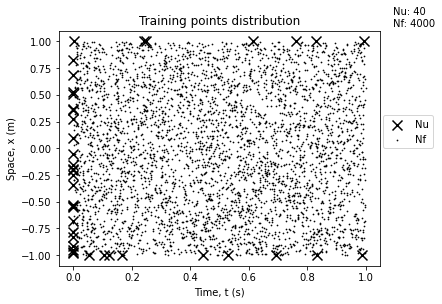

In [7]:
# plot distribution of training points
fig, ax  = plt.subplots(figsize=(6, 4), constrained_layout=True)

ax.scatter(NuArray[:,0],
           NuArray[:,1],
           s=100.,
           c='k',
           marker='x',
           label='Nu',
           )
ax.scatter(NfArray[:,0],
           NfArray[:,1],
           s=2.,
           c='k',
           marker='.',
           label='Nf',
           )

ax.set_title('Training points distribution')
ax.set_xlabel('Time, t (s)')
ax.set_ylabel('Space, x (m)')
ax.legend(loc=(1.01, 0.5))
fig.text(0.9, 0.95, f'Nu: {Nu}\nNf: {Nf}')
fig.savefig(f"/content/gdrive/My Drive/pinns/1DBurg-forw-trainingPoints", bbox_inches='tight')
plt.show()

## Define PINN

In [8]:
# define network characteristics
hiddenLayers = 7
nodesPerLayer = 20
activationFunction = nn.Tanh()
maxIterations = 50000
maxEvaluations = 500000
l1_init = l1
l2_init = l2
inverseProblem = False

# create network and print number of trainable parameters
model = physicsInformedNeuralNetworks.PINN_1D_Burgers(hiddenLayers, nodesPerLayer, activationFunction, maxIterations, maxEvaluations, l1_init, l2_init, inverseProblem)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

Network parameters: 3021


## Perform training

In [9]:
# train model
model.trainer(NuArray, NfArray)

Epoch: 1 --- Elapsed time: 0.33s --- Loss: 0.3557053208351135
Epoch: 2 --- Elapsed time: 0.40s --- Loss: 0.3131074905395508
Epoch: 4 --- Elapsed time: 0.52s --- Loss: 0.2942345440387726
Epoch: 8 --- Elapsed time: 0.79s --- Loss: 0.2892099916934967
Epoch: 16 --- Elapsed time: 1.33s --- Loss: 599.6077880859375
Epoch: 32 --- Elapsed time: 2.32s --- Loss: 0.2036297768354416
Epoch: 64 --- Elapsed time: 4.22s --- Loss: 0.144267737865448
Epoch: 128 --- Elapsed time: 8.52s --- Loss: 0.09000688791275024
Epoch: 256 --- Elapsed time: 17.10s --- Loss: 0.05037016421556473
Epoch: 500 --- Elapsed time: 35.75s --- Loss: 0.009943162091076374
Epoch: 1000 --- Elapsed time: 77.68s --- Loss: 0.0010439320467412472
Epoch: 1500 --- Elapsed time: 122.20s --- Loss: 0.0002615076082292944
Epoch: 2000 --- Elapsed time: 163.04s --- Loss: 0.00013084396778140217
Epoch: 2500 --- Elapsed time: 200.10s --- Loss: 6.79585718899034e-05
Epoch: 3000 --- Elapsed time: 239.24s --- Loss: 2.1577347069978714e-05
Epoch: 3500 --- E

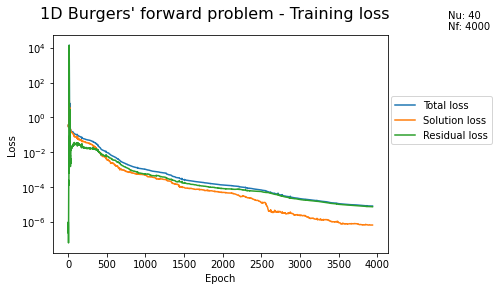

In [20]:
# plot training loss curves
fig = utilityFunctions.trainingHistoryPlot(model.history, ['Total loss', 'Solution loss', 'Residual loss'], 'Loss', "1D Burgers' forward problem - Training loss", yLogAx=True)

fig.text(1.04, 0.9, f'Nu: {Nu}\nNf: {Nf}')

fig.savefig(f"/content/gdrive/My Drive/pinns/1DBurgForw - Loss curve", bbox_inches='tight')

plt.show()

## Generate solution

In [21]:
# compute meshgrid, solution and residual
# arguments: (model, xDim, yDim, xMin, xMax, yMin, yMax, xArg, yArg, residual=True)
mesh_x, mesh_y, PINN_solution, PINN_residual = utilityFunctions.create2dMeshData_1dBurgers(model, num_tPoints, num_xPoints, tMin, tMax, xMin, xMax, 't', 'x', residual=True)

relativeErr2 = np.linalg.norm(FD_solution-PINN_solution, 2) / np.linalg.norm(FD_solution, 2)

In [22]:
relativeErr2

0.02744594106264379

## Results

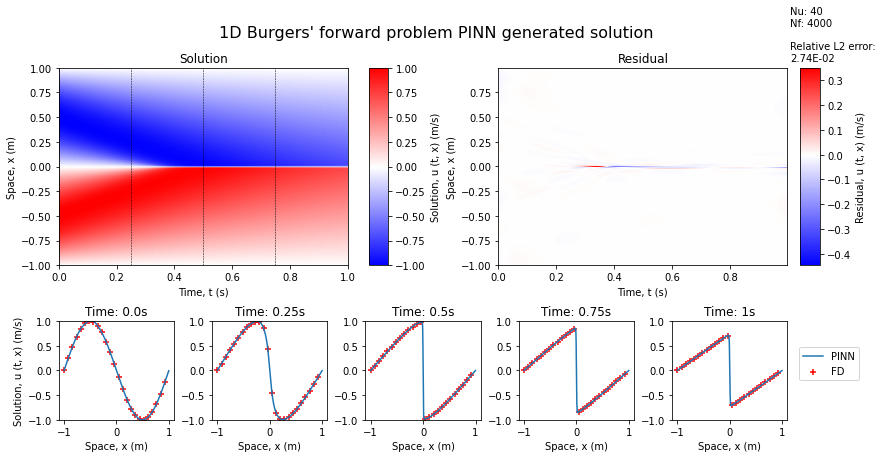

In [38]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(mesh_x, mesh_y, PINN_solution, cmap='bwr', vmin=-1, vmax=1)
solutionAx.set_xlim([0, 1])
solutionAx.set_ylim([-1, 1])

solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
norm = TwoSlopeNorm(vcenter=0)
residualPlot = residualAx.pcolormesh(mesh_x, mesh_y, PINN_residual, cmap='bwr', norm=norm)
residualAx.set_title('Residual')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

markEvery = np.arange(0, FD_solution.shape[1], 40)

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(mesh_y[:, i*(mesh_y.shape[1]//4)], PINN_solution[:, i*(mesh_y.shape[1]//4)])

        tPlot.scatter(mesh_y[:, i*(mesh_y.shape[1]//4)][markEvery], FD_solution[:, i*(mesh_y.shape[1]//4)][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      )

        tPlot.set_title('Time: ' + str(i*mesh_x[0, mesh_x[0].shape[0]//4]) + 's')
        # add vertical lines to solution plot to indicate snapshots
        solutionAx.vlines(x=i*mesh_x[0, mesh_x[0].shape[0]//4], ymin=mesh_y[0,0], ymax=mesh_y[-1,0], colors='black', ls='--', lw=0.5)
    else:
        tPlot.plot(mesh_y[:, -1], PINN_solution[:, -1],
                   label='PINN',
                   )

        tPlot.scatter(mesh_y[:, -1][markEvery], FD_solution[:, -1][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      label='FD',
                      )
        
        tPlot.legend(loc=[1.1, 0.4])

        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

fig.text(0.91, 0.91, f'Nu: {Nu}\nNf: {Nf}\n\nRelative L2 error:\n{(relativeErr2):.2E}')
# figure title
fig.suptitle("1D Burgers' forward problem PINN generated solution", fontsize=16)

fig.savefig(f"/content/gdrive/My Drive/pinns/1D Burgers' forward solution", bbox_inches='tight')
plt.show()

## Extra

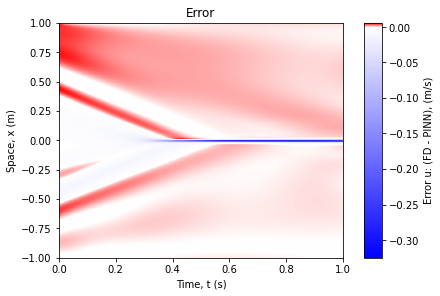

In [30]:
fig = plt.figure(
    figsize=(6, 4),
    constrained_layout=True
    )
gs = GridSpec(1, 1, figure=fig)
norm = TwoSlopeNorm(vcenter=0)

errorAx = fig.add_subplot(gs[:,:])
errorPlot = errorAx.pcolormesh(mesh_x, mesh_y, FD_solution - PINN_solution, cmap='bwr', norm=norm)

errorAx.set_xlim([0, 1])
errorAx.set_ylim([-1, 1])

errorAx.set_title('Error')
errorAx.set_xlabel('Time, t (s)')
errorAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(errorPlot, use_gridspec=True)
cbar.set_label('Error u: (FD - PINN), (m/s)')